In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_curve, confusion_matrix, f1_score
import numpy as np
from sklearn.model_selection import train_test_split
from itertools import repeat, chain
from sklearn.linear_model import LogisticRegression

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import xgboost as xgb

In [657]:
def test_features(df, aoc = False, save_model=False, shap_map=False):
    X_train, X_test, y_train, y_test = (train_test_split(df.iloc[:,1:],df.rating,test_size=0.1, random_state=42))
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.115, random_state=42)
    gbm = (xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=6,
                        objective='binary:logistic', #new objective
                        learning_rate=.05,
                        min_child_weight=3,
                        colsample_bytree=.8
                       ))
    eval_set=[(X_train,y_train),(X_val,y_val)]
    gbm_fit = (gbm.fit(X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='logloss', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   ))
    if aoc==True:
        fpr, tpr, _ = roc_curve(y_te, rf.predict_proba(X_te)[:,1])
        plt.plot(fpr, tpr)
        fpr, tpr, _ = roc_curve(y_te, lr.predict_proba(X_te)[:,1])
        plt.plot(fpr, tpr)
        fpr, tpr, _ = roc_curve(y_te, ada.predict_proba(X_te)[:,1])
        plt.plot(fpr, tpr)
        fpr, tpr, _ = roc_curve(y_test, gbm_fit.predict(X_test))
        plt.plot(fpr, tpr)
        fpr, tpr, _ = roc_curve(y_te_bias, rf_bias.predict_proba(X_te_bias)[:,1])
        plt.plot(fpr, tpr)
        x = np.linspace(0,1, 100000)
        plt.plot(x, x, linestyle='--')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(['Random Forest', 'Logistic Regression', 'AdaBoost', 'XGBoost','RF Bias'])
        plt.show()
    print(f'F1 score: {f1_score(y_test, gbm.predict(X_test))}')
    print(f'Confusion Matrix:')
    print(confusion_matrix(y_test, gbm.predict(X_test)))
    if shap_map == True:
        exp = TreeExplainer(gbm_fit)
        shap_vals = exp.shap_values(X_test)
        shap_df = pd.DataFrame(shap_vals, columns=pd.Index(df.columns[1:], name='genres'))
        shap.summary_plot(shap_vals, X_test)
    if save_model == True:
        return X_test, y_test, gbm_fit

In [699]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
namestr(ada, globals())[0]

'ada'

In [2]:
revert_dict = lambda d: dict(chain(*[zip(val, repeat(key)) for key, val in d.items()]))
def get_rankings(item, df):
    
    # Empty dict for results
    item_count_dict = {}
    
    # For every tag in df
    for i in range(df.shape[1]):
        
        # Calculate % of cases that tagged the item
        val_counts = df.iloc[:,i].value_counts(normalize = True)
        if item in val_counts.index:
            item_counts = val_counts[item]
        else:
            item_counts = 0
        
        # Add score to dict
        item_count_dict["tag_{}".format(i)] = item_counts
    
    return item_count_dict
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])
def list_as_cols(item_lists, unique_items):
# Create empty dict
    bool_dict = {}   
    # Loop through all the tags
    for i, item in enumerate(unique_items):       
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: item in x)         
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict).dtype('int')
def get_genre_aggregations(df, genres, aggs, suffix=''):    
    agg_dfs = ([(df[df[genre]==1].groupby(['reader_id'], as_index=False)
                                 .agg(aggs)
                                 .set_index('reader_id')) for genre in genres])
    genre_agg_df = pd.concat(agg_dfs, axis=1)
    genre_agg_df.columns = [genre + suffix for genre in genres]
    return genre_agg_df
def get_dist_perc(x):
    star = int(x['reader_rating']-1)
    return ( (x[stars[star]]/2) + x[stars[:star]].sum() ) / x[stars].sum()
def get_likelihood(x):
    star = int(x['reader_rating']-1)
    return x[stars[star]] / x[stars].sum()
def get_median(x):
    median = x[stars].sum()/2
    for star in range(1,6):
        if median <= x[stars[:int(star)]].sum():
            return star
def grouped_shap(shap_vals, features, groups):
    groupmap = revert_dict(groups)
    shap_Tdf = pd.DataFrame(shap_vals, columns=pd.Index(features, name='features')).T
    shap_Tdf['group'] = shap_Tdf.reset_index().features.map(groupmap).values
    shap_grouped = shap_Tdf.groupby('group').sum().T
    return shap_grouped

#### Import & Wrangle

In [20]:
readers = pd.read_csv('Data/readers.csv').drop_duplicates()
readers_books = pd.read_csv('Data/readers_books.csv')
books = pd.read_csv('Data/Books/all_books.csv')

readers = pd.read_csv('Data/readers.csv').drop_duplicates().dropna() #some readers did not rate the book
readers_books = readers_books[(readers_books.reader_id.isin(readers.reader_id))&(readers_books.book_id!=1162022)]
readers = readers[readers.reader_id.isin(readers_books.reader_id)] # Filter out readers with private profiles
# The target book rating in reading hist should not be used to train the model. 

In [ ]:
# Get books' rating distribution
books_stars = books.iloc[:,[1,-1]]
books_stars["rating_distribution"] = books_stars["rating_distribution"].apply(eval)
stars = ['1 Star','2 Stars','3 Stars','4 Stars','5 Stars']
for star in stars:
    books_stars[star] = books_stars.loc[:,'rating_distribution'].apply(lambda x: x[star])
books_stars['book_median'] = books_stars.apply(get_median, axis=1)
books_stars.head(2)

In [6]:
readers_books_dist = (readers_books.loc[:,['reader_id','reader_rating','book_id','book_avg_rating']]
                      .merge(books_stars.drop(columns=['rating_distribution']), on='book_id', how='inner'))
readers_books_dist['rating_percentile'] = readers_books_dist.apply(get_dist_perc, axis=1)
readers_books_dist['rating_likelihood'] = readers_books_dist.apply(get_likelihood, axis=1)
readers_books_dist['bias_median'] = readers_books_dist.reader_rating - readers_books_dist.book_median
readers_books_dist['bias_mean'] = readers_books_dist.reader_rating - readers_books_dist.book_avg_rating

In [11]:
readers_books_genres = (readers_books_dist.iloc[:,[0,1,2,3,10,11,12,13]]
                        .merge(books.iloc[:,[1,10]], on='book_id', how='inner'))
my_genres = to_1D(readers_books_genres.genres.apply(eval)).value_counts().drop('Audiobook').index

In [716]:
#with open("Data/ordered_genre_list.txt", "w") as f:
#    for genre in my_genres:
#        f.write(genre +"\n")

In [12]:
readers_books_genres.reader_id.nunique()

3046

In [447]:
from sklearn.preprocessing import MultiLabelBinarizer

s = readers_books_genres['genres'].apply(eval)

mlb = MultiLabelBinarizer()

reader_genres = (pd.concat([
    readers_books_genres,
    pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=readers_books_genres.index)
    ], axis=1))

#### Small baseline test for few (popular) features
Can be tested on models that don't need imputation

In [714]:
readers.head(2)

,rating,reader_id
0,5.0,4622890
1,5.0,4632071


In [ ]:
baseline_df = pd.concat([readers.set_index('reader_id'),
                       get_genre_aggregations(reader_genres,
                                              ['Romance','Young Adult','Fiction'],
                                              {'reader_bias_mean':'mean'})],
                      axis=1)
baseline_df['rating'] = (baseline_df.rating>=4).astype('int')
#sns.pairplot(bias_test, hue='rating')

In [ ]:
X_tr, X_te, y_tr, y_te = (train_test_split(baseline_df.dropna().iloc[:,1:], baseline_df.dropna().rating,
                                           test_size=.2, random_state=42)
rf = RandomForestClassifier().fit(X_tr, y_tr)
lr = LogisticRegression(C=100).fit(X_tr, y_tr)
ada = AdaBoostClassifier().fit(X_tr, y_tr)

std = StandardScaler()
std.fit(X_tr)
X_tr_sc, X_te_sc = std.transform(X_tr), std.transform(X_te) 
knn = KNeighborsClassifier().fit(X_tr_sc, y_tr)

In [ ]:
fpr, tpr, _ = roc_curve(y_te, rf.predict_proba(X_te)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_te, lr.predict_proba(X_te)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_te, ada.predict_proba(X_te)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_te_sc, knn.predict_proba(X_te_sc)[:,1])
plt.plot(fpr, tpr)

x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Random Forest', 'Logistic Regression', 'AdaBoost', 'kNN'])

In [395]:
#XGBoost with all genres' biases (can handle missing values)
X_train, X_test, y_train, y_test = (train_test_split(bias_test_lg.iloc[:,1:],
                                                     bias_test_lg.rating,
                                                     test_size=0.1, random_state=1))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.115, random_state=2)

gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=6,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
gbm_fit = gbm.fit(X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='logloss', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


In [394]:
bias_test_lg = pd.concat([readers.set_index('reader_id'),
                       get_genre_aggregations(reader_genres,
                                              my_genres[:150],
                                              {'reader_bias_mean':'mean'})],
                      axis=1)
bias_test_lg['rating'] = (bias_test_lg.rating>=4).astype('int')

In [384]:
# Random Forest with just overall reader bias
avg_bias_test = (pd.concat([readers.set_index('reader_id'),
                           reader_genres.groupby('reader_id')['reader_bias_mean'].mean()], axis=1).dropna())
avg_bias_test['rating'] = (avg_bias_test.rating<=4).astype('int')
X_tr_bias, X_te_bias, y_tr_bias, y_te_bias = (train_test_split(avg_bias_test[['reader_bias_mean']], avg_bias_test.rating,
                                           test_size=.2, random_state=42))
rf_bias = RandomForestClassifier()
rf_bias.fit(X_tr_bias, y_tr_bias)

RandomForestClassifier()

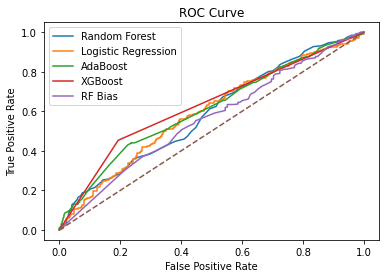

In [396]:
X = baseline_df.dropna().iloc[:,1:]
y = baseline_df.dropna().rating
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=.2, random_state=42)


rf = RandomForestClassifier()
rf.fit(X_tr, y_tr)

lr = LogisticRegression(C=100)
lr.fit(X_tr, y_tr)

ada = AdaBoostClassifier()
ada.fit(X_tr, y_tr)


fpr, tpr, _ = roc_curve(y_te, rf.predict_proba(X_te)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_te, lr.predict_proba(X_te)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_te, ada.predict_proba(X_te)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_test, gbm_fit.predict(X_test))
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_te_bias, rf_bias.predict_proba(X_te_bias)[:,1])
plt.plot(fpr, tpr)

x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Random Forest', 'Logistic Regression', 'AdaBoost', 'XGBoost','RF Bias'])

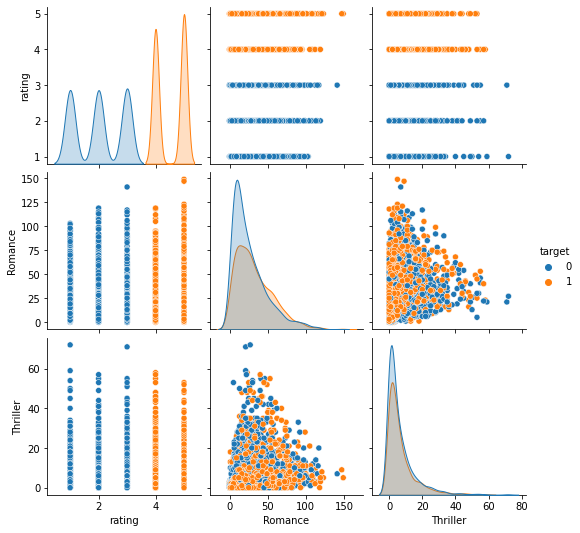

In [193]:
romance_nr = (pd.concat([readers.set_index('reader_id'),
                         reader_genres.groupby('reader_id')['Romance'].sum(),
                         reader_genres.groupby('reader_id')['Thriller'].sum()], axis=1)
              .dropna())
romance_nr['target'] = (romance_nr.rating>=4).astype('int')

sns.pairplot(romance_nr, hue='target')

#### Shap Tests

In [ ]:
import shap
from shap import TreeExplainer

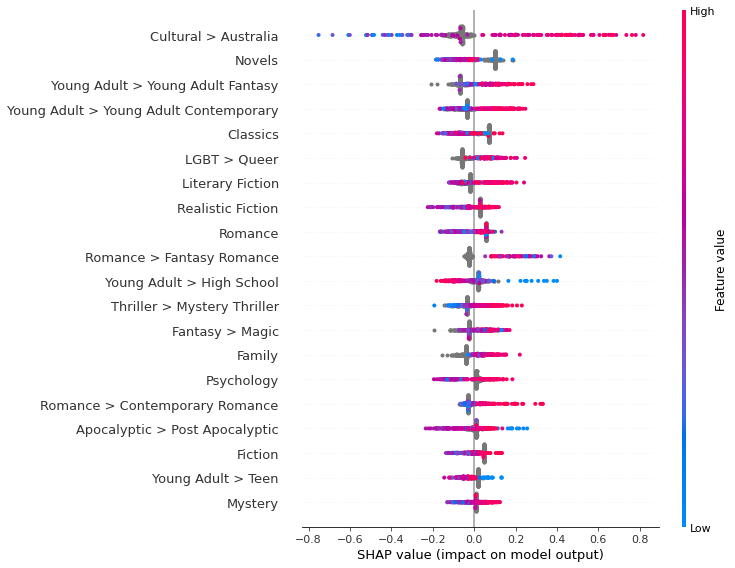

In [399]:
#XGBoost
exp = TreeExplainer(gbm_fit)
 
shap_vals = exp.shap_values(X_test)
shap_df = pd.DataFrame(shap_vals, columns=pd.Index(my_genres[:150], name='genres'))
shap.summary_plot(shap_vals, X_test)

#### Grouped Features

divergence from book avg rating

In [717]:
div_from_mean = pd.concat([readers.set_index('reader_id'),
                             get_genre_aggregations(reader_genres, my_genres[:100], {'bias_mean':'mean'},
                                                   ' mean')], axis=1, join='inner')
div_from_mean['rating'] = (div_from_mean.rating>=4.0).astype('int')

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


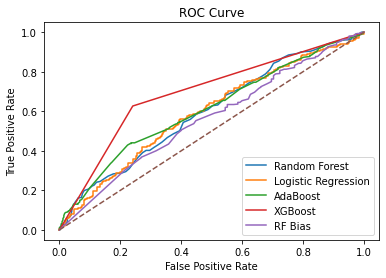

F1 score: 0.6568265682656826
Confusion Matrix:
[[126  40]
 [ 53  89]]


In [718]:
test_features(div_from_mean, aoc=True)

divergence from book median rating

In [704]:
div_from_median = pd.concat([readers.set_index('reader_id'),
                             get_genre_aggregations(reader_genres, my_genres[:100],{'bias_median':'mean'},
                                                   ' median')], axis=1, join='inner')
div_from_median['rating'] = (div_from_median.rating>=4.0).astype('int')

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


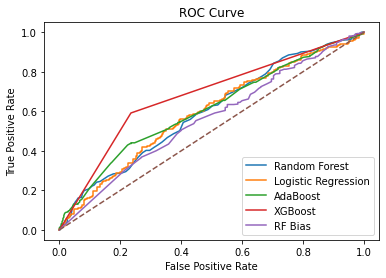

F1 score: 0.6339622641509435
Confusion Matrix:
[[127  39]
 [ 58  84]]


In [668]:
test_features(div_from_median, aoc=True)

Percentile within books'distributions, aggregated by genre

In [705]:
percentile = pd.concat([readers.set_index('reader_id'),
                             get_genre_aggregations(reader_genres, my_genres[:100],{'rating_percentile':'mean'},
                                                   ' percentile')], axis=1, join='inner')
percentile['rating'] = (percentile.rating>=4.0).astype('int')

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


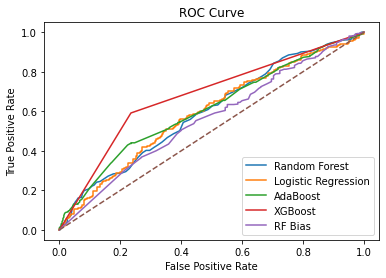

F1 score: 0.6339622641509435
Confusion Matrix:
[[127  39]
 [ 58  84]]


In [670]:
test_features(div_from_median, aoc=True)

Nr books read per genre

In [706]:
count_genre = pd.concat([readers.set_index('reader_id'),
                             get_genre_aggregations(reader_genres, my_genres[:100],{'rating_percentile':'count'},
                                                   ' freq')], axis=1, join='inner')
count_genre['rating'] = (count_genre.rating>=4.0).astype('int')

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


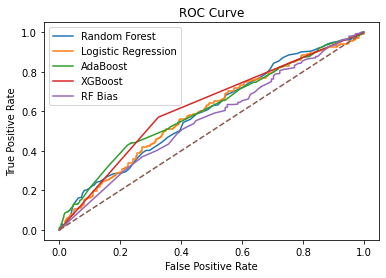

F1 score: 0.5848375451263538
Confusion Matrix:
[[112  54]
 [ 61  81]]


In [674]:
test_features(count_genre, aoc=True)

All groups 

In [691]:
groups = {'Divergence from book mean': [genre + ' mean' for genre in my_genres[:80]],
          'Diverge from book median':[genre + ' median' for genre in my_genres[:80]],
          'Rating percentile in book dist': [genre +' percentile' for genre in my_genres[:80]],
          'Nr books read': [genre + 'nr books' for genre in my_genres[:80]]}
grouped_genres = (pd.concat([div_from_median.iloc[:,:81], div_from_mean.iloc[:,1:81],
                             percentile.iloc[:,1:81]], axis=1))

In [692]:
X_test, y_test, gbm_group = test_features(grouped_genres, save_model=True)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


F1 score: 0.704225352112676
Confusion Matrix:
[[124  42]
 [ 42 100]]


In [708]:
reader_genres.shape

(199167, 471)

In [713]:
#(pd.concat([div_from_median, div_from_mean.iloc[:,1:], percentile.iloc[:,1:], count_genre.iloc[:,1:]], axis=1)
#    .to_csv('Data/genre_features.csv'))
reader_genres.to_csv('Data/reader_genre.csv', index=False)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


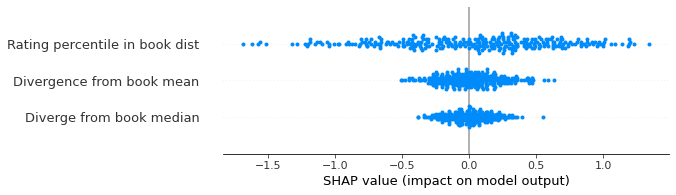

In [677]:
exp = TreeExplainer(gbm_group)
shap_vals = exp.shap_values(X_test)
shap_group = grouped_shap(shap_vals, grouped_genres.columns[1:], groups)
shap.summary_plot(shap_group.values, features=shap_group.columns)

#### Genre Correlation Matrix

In [121]:
def boolean_df(item_lists, unique_genres):
    bool_dict = {}
    for i, item in enumerate(unique_genres):
        bool_dict[item] = item_lists.apply(lambda x: item in x)
    return pd.DataFrame(bool_dict)

In [142]:
genres_matrix = boolean_df(books.genres, unique_genres[:50]).astype('int')
genres_freq_mat = np.dot(genres_matrix.T, genres_matrix)

In [143]:
genres_freq = pd.DataFrame(genres_freq_mat, columns = unique_genres[:50], index = unique_genres[:50])

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0.5, 0, 'Fantasy > Urban Fantasy'),
  Text(1.5, 0, 'New Adult'),
  Text(2.5, 0, 'Science Fiction > Dystopia'),
  Text(3.5, 0, 'Family'),
  Text(4.5, 0, 'Suspense'),
  Text(5.5, 0, 'Literature'),
  Text(6.5, 0, 'Young Adult > Young Adult Contemporary'),
  Text(7.5, 0, 'Horror'),
  Text(8.5, 0, 'LGBT > Queer'),
  Text(9.5, 0, 'Fantasy > Supernatural')])

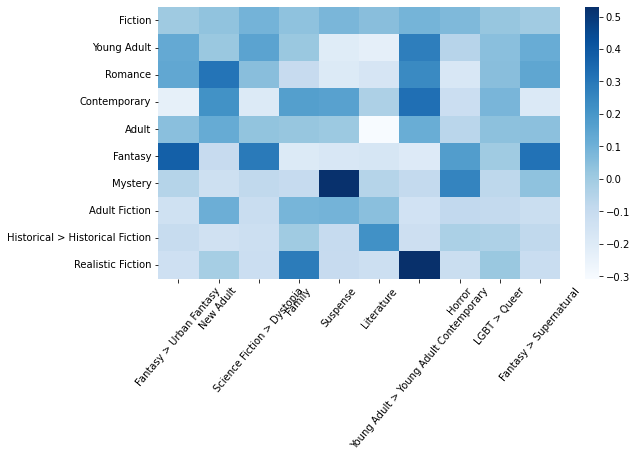

In [155]:
genres_corr = genres_matrix.corr(method = "pearson")
fig, ax = plt.subplots(figsize = (9,5))
sns.heatmap(genres_corr.iloc[:10,30:40], cmap = "Blues")
plt.xticks(rotation=50)

In [723]:
genres_corr.loc[:,:] =  np.tril(genres_corr.values, k=-1)
corr_stack = genres_corr.stack()

In [808]:
(len([genre[0] for genre in corr_stack[abs(corr_stack)>=.75].index]))

50

In [798]:
(corr_stack[(corr_stack>=.74)&(corr_stack<.75)])

Biography > Autobiography  Biography Memoir                0.749954
Historical > Regency       Romance > Historical Romance    0.743607
Art                        Graphic Novels Comics           0.745553
dtype: float64

In [765]:
len(my_genres)

460

#### See rating within book distribution

In [302]:
books_stars.head()

,book_id,rating_distribution,1 Star,2 Stars,3 Stars,4 Stars,5 Stars,median_rating
0,45023611,"{'5 Stars': 8454, '4 Stars': 16217, '3 Stars':...",824,3067,12083,16217,8454,4
1,13662,"{'5 Stars': 38599, '4 Stars': 39593, '3 Stars'...",1302,3514,18726,39593,38599,4
2,1087204,"{'5 Stars': 97788, '4 Stars': 35181, '3 Stars'...",3545,4863,17782,35181,97788,5
3,17165932,"{'5 Stars': 11458, '4 Stars': 14506, '3 Stars'...",322,1695,8220,14506,11458,4
4,52397,"{'5 Stars': 44869, '4 Stars': 38190, '3 Stars'...",1535,3458,14729,38190,44869,4


In [243]:
books_stars = books.iloc[:,[1,-1]]
books_stars["rating_distribution"] = books_stars["rating_distribution"].apply(eval)
stars = ['1 Star','2 Stars','3 Stars','4 Stars','5 Stars']
for star in stars:
    books_stars[star] = books_stars.loc[:,'rating_distribution'].apply(lambda x: x[star])
books_stars['median_rating'] = books_stars.apply(get_median, axis=1)

In [264]:
readers_books_dist.head()

,reader_id,reader_rating,book_id,1 Star,2 Stars,3 Stars,4 Stars,5 Stars
0,2250020,4,45023611,824,3067,12083,16217,8454
1,30248594,4,45023611,824,3067,12083,16217,8454
2,4863162,3,45023611,824,3067,12083,16217,8454
3,5873788,2,45023611,824,3067,12083,16217,8454
4,584261,4,45023611,824,3067,12083,16217,8454


In [271]:
readers_books_dist = (readers_books.loc[:,['reader_id','reader_rating','book_id']]
                      .merge(books_stars.drop(columns=['rating_distribution']), on='book_id', how='right'))
readers_books_dist['distr_percentile'] = readers_books_dist.apply(get_dist_rank, axis=1)
readers_books_dist['rating_likelihood'] = readers_books_dist.apply(get_likelihood, axis=1)
readers_books_dist['bias_median'] = readers_books_dist.reader_rating - readers_books_dist.median_rating